<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px">

# Introduction to A/B Testing

Week 11 | Lesson 1.1

---

A/B  (A/B/C/etc.) split testing is a popular and ubiquitous technique for improving products in industry (particular the tech industry).

The main topics of this lecture are the design and the ways of "winnering" a split test.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#import prettyplotlib as ppl

sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import Image


---

## A/B Test Design

An example of an A/B test might be:

>Google wants to test if changing the size of the information card on the right side of the search results page will result in more people clicking on links inside of it. They construct two versions of their search results page, one with the original, "control" page where the box is 300px wide, and a new "experimental" page where the box is 301px wide.
        
>For one day, they funnel 90% of searchers to the control page and 10% to the experimental page. At the end of the day, they check the click rates for each and determine a winner.


Good A/B test design applies scientific standards borrowed from experimental design in science. As is described above, A/B tests are really just experiments and hypothesis testing with a different name and context.


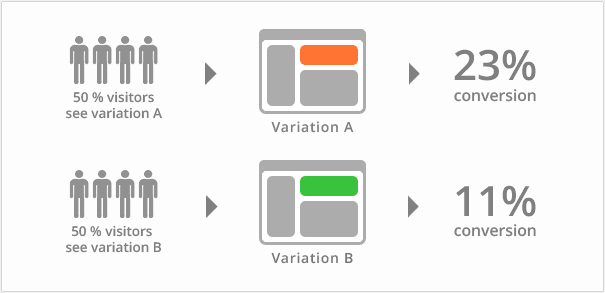

In [2]:
Image(filename='./assets/images/ab_test1.png', width=900) 

---

## A/B Testing Case Studies

In groups read about A/B testing case studies, discuss, and then present to the class on what the findings and outcome of the case study was.


#### Case study 1: How Obama raised 60 million dollars

https://blog.optimizely.com/2010/11/29/how-obama-raised-60-million-by-running-a-simple-experiment/

#### Case study 2: How AMD increased social sharing by 3600%

https://vwo.com/blog/amd-3600-social-sharing-increase/

#### Case study 3: Failed A/B tests increase conversion

http://unbounce.com/a-b-testing/failed-ab-test-results/

#### Case study 4: When good design is bad for business

https://vwo.com/blog/good-design-bad-conversion-rate/



---

### Setup of a Split Test

Companies running as split test, and particularly the data scientists responsible for the construction and analysis of the test, should consider in detail the value, purpose, and setup of the test before beginning any _technical_ work. Four essential considerations before beginning a test are:

**1. WHAT ELEMENTS WILL BE CHANGED IN THE PRODUCT?**

Data scientist typically work closely with Product or Project Managers (PMs). You will often have limited say in what elements are changed for a test, but this does not mean you should avoid "weighing in". In fact, it is essential as a data scientist to clearly communicate your opinion of the test since you are the most statistically savvy. At this stage in the process, ensuring the smallest/most limited changes are made will prevent false correlations in the data and have the most meaningful results.

**2. WHO WILL BE PART OF THE TESTING GROUPS (ARMS) AND BY HOW MUCH?**

Will the test split incoming traffic 50/50 between variants? Should you serve the variant under test to a smaller group? Will the test split change? A common and safe practice is to begin by only showing the new variant(s) to a very small proportion of users to ensure there is nothing very wrong with the change, then performing the actual split test on a larger proportion of users.

**3. HOW LONG WILL THE TEST RUN?**

This is a very important question to ask. If the test doesn't run long enough, your data won't be useful. If it runs too long, that can impact business needs. _In the standard split test procedure, you cannot check the results multiple times!_ We will examine and explain why in a later section.

**4. IS THE THE TEST NECESSARY? WHY?**

A/B testing is a gamble, and potentially an expensive one. If the business result of the test is less valuable than the possible negative effects on churn or conversion rate, then it is worth re-evaluating your variants and design.

---

### Requirements of the Standard Split Test

As with any scientific test, there are requirements for ensuring that the experimental design and results are valid. Below are described the requirements for constructing a _standard_ split test, though variations exist that attempt to get around one or more of these.

---

**SPLIT TEST REQUIREMENTS**

1. **Randomized design:** users are randomly assigned to one of the arms of the test as they visit the site/app. 
- **Win criteria set in advance:** you must decide before running the test what the condition for accepting a change will be.
- **One thing changed per test:** the control and experiemental conditions only vary on one change. Note that more than one change per arm is not statistically invalid, but makes results difficult or impossible to interperet.
- **Split test is evaluated only once:** The test ends at a specific point – there is no "peeking" at the rates as the test runs.

The final point is the most commonly violated and also the biggest pain point when working with other departments in your company. The most popular variations on the standard split test design try to address this issue. We will discuss this more in depth later.

---

**TWO COMMON SPLIT TEST MISCONCEPTIONS**

1. **Split testing can only compare two versions.** This is not true, and multiple arm tests are often referred to as A/B/C, A/B/C/D, etc.
2. **Split test arms must have equal fractions of users.** There is no statistical reason that your arms must have equal splits (other than requiring fewer data points).


---

## Analysis of Split Test Results

The jargon for choosing the best version and applying it to all users is "winnering" an arm of the test. This process is the same as doing a hypothesis test such as a t-test to compare the two mean rates.

We will load and analyze the results of a simple A/B test on click-through rates for a website in the dataset below:

In [3]:
abtest = pd.read_csv('./assets/datasets/CTR.csv')


The data columns are:

    clicks_converted: the number of clicks that ended up in a "conversion", which is the number of users who continued into the site beyond this landing page
    clicks_left: the number of users who left the site after clicking into this landing page
    test_variant: a 1/0 coded column indicating which of the two arms of the test this measurement was from.
    
Rows in this dataset are measurements taken at different times separately for each arm. There were 1000 total measurements made before the test was stopped, and the test is not evenly split as only 28.5% of users recieved variant 1 (the "experimental" arm).

---

### Aggregate and Plot Conversion Data

Aggregate the number of clicks converted and clicks left by test variant, then plot the differences using a barplot.

In [4]:
abtest.head(2)

,clicks_converted,clicks_left,test_variant
0,11,19,0
1,10,20,0


In [5]:
ab_agg = abtest.groupby('test_variant').sum().reset_index()
ab_agg

,test_variant,clicks_converted,clicks_left
0,0,8615,14181
1,1,6197,5724


In [6]:
ab_agg_long = pd.melt(ab_agg, id_vars=['test_variant'],
                      var_name='outcome', value_name='count')
ab_agg_long

,test_variant,outcome,count
0,0,clicks_converted,8615
1,1,clicks_converted,6197
2,0,clicks_left,14181
3,1,clicks_left,5724


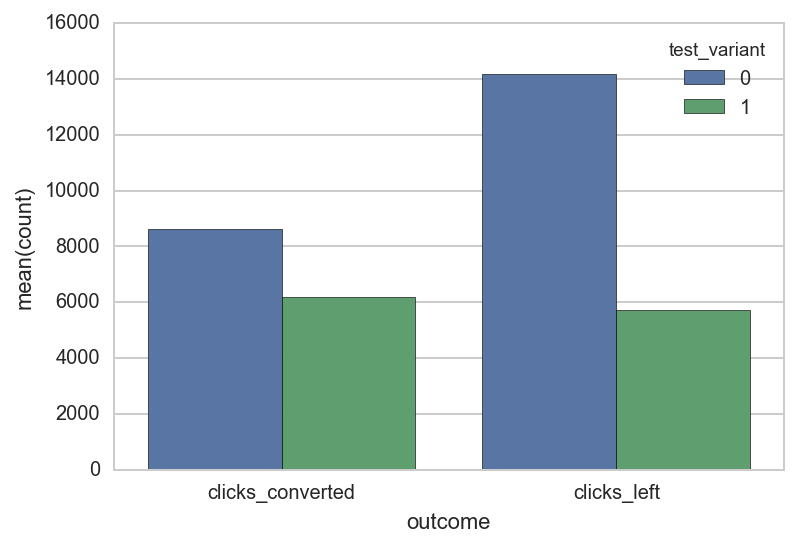

In [7]:
sns.barplot(x='outcome', y='count', data=ab_agg_long, hue='test_variant')

---

### Analyzing Results with the Chi-square Test

It's pretty obvious from the above chart which of the two is achieving the higher click-through rate per user, but you always need to do a rigorous statistical test.

A basic statistical method for evaluating this test is the **chi-square test of independence.** Essentially, the chi-square test is a procedure to determine if the observed distribution of categorical variables is independent or not. In the context here, it tells us the probability that our arms come from the same distribution. 

If the likelihood of dependence is low, then we can assume that the measured mean counts of arms (rates of conversion) are not the same, which is the null hypothesis.

For more information see:

http://www.ling.upenn.edu/~clight/chisquared.htm

http://thestatsgeek.com/2013/07/22/ab-testing/


#### Calculate the chi-square p-value below and describe what it means:

You can use the `chi2_contingency()` function to calculate this on a contingency table matrix.

http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.chi2_contingency.html


In [8]:
from scipy.stats import chi2_contingency

contingency = ab_agg[['clicks_converted', 'clicks_left']].values
print contingency

[[ 8615 14181]
 [ 6197  5724]]


In [9]:
chi_sq_stat, chi_sq_pvalue, _, _ = chi2_contingency(contingency)
print chi_sq_stat, chi_sq_pvalue

643.938809137 4.64847157614e-142


---

### Analyzing Results with a T-test

As you may recall, the **student's t-test** is a method for examining whether the mean of two distributions are different. Our null hypothesis is that the means are not different between arms, and likewise the alternative hypothesis is that they are.

You can also use the similar z-test to calculate difference of means for split tests, and some do, but I prefer student's t-test as it can assume that the variances are not equal between distributions.

#### Calculate the two-tailed t-test below

You can use the `ttest_ind()` function from `scipy.stats` to do the calculation. 

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

T-tests can be "one-tailed" or "two-tailed". If you've forgotten what these refer to look it up on Google! Explain why the two-tailed is more appropriate.

In [10]:
abtest.head(2)

,clicks_converted,clicks_left,test_variant
0,11,19,0
1,10,20,0


In [11]:
abtest['convert_rate'] = abtest.clicks_converted / (abtest.clicks_converted + abtest.clicks_left)

In [12]:
abtest.head(2)

,clicks_converted,clicks_left,test_variant,convert_rate
0,11,19,0,0.366667
1,10,20,0,0.333333


In [13]:
arm_A_rates = abtest[abtest.test_variant == 0].convert_rate.values
arm_B_rates = abtest[abtest.test_variant == 1].convert_rate.values

In [14]:
from scipy.stats import ttest_ind

In [15]:
tval, t_pval = ttest_ind(arm_A_rates, arm_B_rates, equal_var=False)
print tval, t_pval

-26.6625466199 3.83422923362e-103


---

## LAB: The danger of "peeking" – examining the results of your split test over time.

Analyzing the results of a split test multiple times over time is one of the most common and dangerous mistakes that statistically uninformed analysts make. It is actually pretty shocking how much this is done, though people are much better about it now. As a data scientist it is essential that you enforce no "peeking" multiple times at the state of the split test results.

To look at why this is the case, we will look at peeking vs not peeking on fake split tests below.

---

### Conversion function

You are provided with a function `split_test_results(user_count, arm)` that will accept a number of "users" and an arm ("A" or "B"). The function returns the number of conversions and the number that left in a list.

In [27]:
from numpy.random import binomial

def split_test_results(user_count, arm='A'):
    
    if arm == 'A':
        a = binomial(1, .08, size=user_count)
        return [np.sum(a), user_count - np.sum(a)]
    
    if arm == 'B':
        b = binomial(1, .11, size=user_count)
        return [np.sum(b), user_count - np.sum(b)]
    

---

### Create 50 split test results

You will run 50 different split tests that each run for 75 "days" (don't worry about datetime stuff here - just use each row as a day. Datetime manipulation is not the point here.)

The DataFrame for each test should look something like this:

| arm_a_conversions | arm_a_left | arm_b_conversions | arm_b_left | day | split_test_num |
| :---: | :---: | :---: | :---: | :---: | :---: |
| 3 | 7 | 9 | 4 | 1 | 1 |
| 1 | 8 | 10 | 3 | 2 | 1 |
| 4 | 5 | 2 | 11 | 3 | 1 |

Make **arm A take 28 users per day**, and **arm B take 16 users per day**. Again, there should be 75 days per split test and 50 split tests, so the shape of the dataframe will be (3750, 6).


In [28]:
a = [split_test_results(28, arm='A') for i in range(3)]
print a

[[1, 27], [3, 25], [1, 27]]


In [29]:
split_tests = []

for st in range(1, 51):
    a_days = [split_test_results(28, arm='A') for i in range(75)]
    b_days = [split_test_results(16, arm='B') for i in range(75)]
    
    current_st = pd.DataFrame({
            'arm_a_conversions':[x[0] for x in a_days],
            'arm_a_left':[x[1] for x in a_days],
            'arm_b_conversions':[x[0] for x in b_days],
            'arm_b_left':[x[1] for x in b_days],
            'day':np.arange(1,76),
            'split_test_num':[st for i in range(75)]
        })
    
    split_tests.append(current_st)
    
split_tests = pd.concat(split_tests, axis=0)

print split_tests.shape
split_tests.head()



(3750, 6)


,arm_a_conversions,arm_a_left,arm_b_conversions,arm_b_left,day,split_test_num
0,1,27,3,13,1,1
1,3,25,4,12,2,1
2,1,27,4,12,3,1
3,2,26,1,15,4,1
4,2,26,0,16,5,1


---

### Analyze each split test and declare winner on the 75th day

For each of the 50 split tests, analyze the results and determine the winning arm.

Your threshold criterion for choosing arm B over arm A should be **alpha = 0.05.** In other words, the mean rate for arm B, the "experimental" arm, would need to be larger with a significance of p < 0.05 to be accepted as the new version over arm A, the "control" arm.


In [30]:
def chi2_for_75d(st):
    
    contingency = []
    
    a_conv = float(st.arm_a_conversions.sum())
    b_conv = float(st.arm_b_conversions.sum())
    
    a_left = float(st.arm_a_left.sum())
    b_left = float(st.arm_b_left.sum())
    
    contingency.append([a_conv, a_left])
    contingency.append([b_conv, b_left])
    contingency = np.array(contingency)
    
    chi2, pval, _, _ = chi2_contingency(contingency)
    
    a_mean_rate = a_conv / (a_conv + a_left)
    b_mean_rate = b_conv / (b_conv + b_left)
    
    if (pval < 0.05) and (b_mean_rate > a_mean_rate):
        winner = 'B'
    else:
        winner = 'A'
        
    return pd.DataFrame({'winner':[winner], 'a_rate':[a_mean_rate],
                         'b_rate':[b_mean_rate], 'pval':[pval]})
    

chi2_75d = split_tests.groupby('split_test_num').apply(chi2_for_75d).reset_index(drop=True)

In [31]:
chi2_75d.head()

,a_rate,b_rate,pval,winner
0,0.081429,0.117500,0.000823,B
1,0.086190,0.110833,0.023875,B
2,0.079524,0.096667,0.103690,A
3,0.077143,0.125000,0.000008,B
4,0.084762,0.106667,0.042913,B


In [32]:

print chi2_75d[chi2_75d.winner == 'A'].shape[0]
print chi2_75d[chi2_75d.winner == 'B'].shape[0]

14
36


---

### Select winner while "peeking" at the tests.

"Peeking" at split tests is essentially watching the test as it runs, and whatever day it hits the winning condition you declare the winning arm.

You will use the same split test data above, to compare the results of peeking vs. not. Again, your threshold is alpha = 0.05, and arm B is declared the winner if the p-value is less than alpha and the mean rate of B is greater than the mean rate of A. If the p-value goes below the alpha threshold and the mean rate of A is higher, A is winnered.

Create a DataFrame in the following format:

| winning_arm | a_mean_rate | b_mean_rate | day_won | split_test_num |
| :---: | :---: | :---: | :---: | :---: |
| A | 0.12 | 0.04 | 30 | 1 |
| B | 0.03 | 0.11 | 45 | 1 |

In [35]:
# np.cumsum calculates rolling sum
def calc_cumsum(st):
    
    c = pd.DataFrame({
            'a_conv_cs':np.cumsum(st.arm_a_conversions),
            'a_left_cs':np.cumsum(st.arm_a_left),
            'b_conv_cs':np.cumsum(st.arm_b_conversions),
            'b_left_cs':np.cumsum(st.arm_b_left),
            'split_test_num':st.split_test_num,
            'day':st.day
        })
    
    return c


cumulative = split_tests.groupby('split_test_num').apply(calc_cumsum).reset_index(drop=True)

In [36]:
cumulative.head()

,a_conv_cs,a_left_cs,b_conv_cs,b_left_cs,day,split_test_num
0,1,27,3,13,1,1
1,4,52,7,25,2,1
2,5,79,11,37,3,1
3,7,105,12,52,4,1
4,9,131,12,68,5,1


In [45]:

def calc_daily_chi2(st):
    
    a_conv = st.a_conv_cs.values[0]
    a_left = st.a_left_cs.values[0]
    b_conv = st.b_conv_cs.values[0]
    b_left = st.b_left_cs.values[0]
    
    contingency = np.array([[a_conv, a_left],
                            [b_conv, b_left]])
    
    a_rate = a_conv / float(a_conv + a_left)
    b_rate = b_conv / float(b_conv + b_left)
    
    if (a_rate > 0) and (b_rate > 0):
        chi2, pval, _, _ = chi2_contingency(contingency)
    else:
        pval = 1.
    
    if (b_rate > a_rate) and (pval < 0.05):
        winner = 'B'
    else:
        winner = 'A'
        
    return pd.DataFrame({
            'winner':[winner],
            'pval':[pval],
            'day':[st.day.values[0]],
            'split_test_num':[st.split_test_num.values[0]]
        })
    

peeking = cumulative.groupby(['split_test_num','day']).apply(calc_daily_chi2).reset_index(drop=True)

In [46]:
peeking.head()

,day,pval,split_test_num,winner
0,1,0.254417,1,A
1,2,0.093905,1,A
2,3,0.009444,1,B
3,4,0.020441,1,B
4,5,0.065354,1,A


In [47]:
significant = peeking[peeking.pval < 0.05]

In [48]:
significant.sort_values(['split_test_num','day'], inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [49]:
len(significant.split_test_num.unique())

45

In [52]:
first_sig = significant.groupby('split_test_num').apply(lambda st: st.iloc[0,:]).reset_index(drop=True)

In [53]:
first_sig.head()

,day,pval,split_test_num,winner
0,3,0.009444,1,B
1,36,0.046776,2,B
2,19,0.042780,3,B
3,16,0.037205,4,B
4,72,0.039170,5,B


In [55]:
print 'Day 75 results:'
print chi2_75d[chi2_75d.winner == 'A'].shape[0]
print chi2_75d[chi2_75d.winner == 'B'].shape[0]

print '\nPeeking results:'
print first_sig[first_sig.winner == 'A'].shape[0]+5
print first_sig[first_sig.winner == 'B'].shape[0]



Day 75 results:
14
36

Peeking results:
5
45
